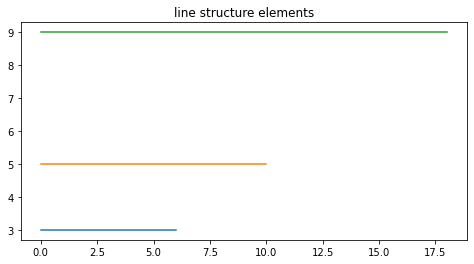

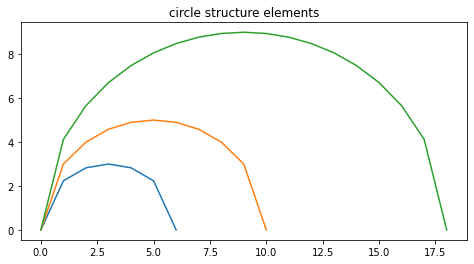

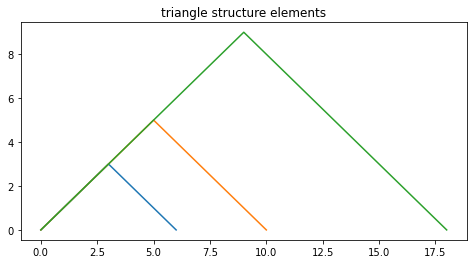

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def structure_element(radius,types):
  #type: 0-line,1-circle,2-triangle
  se = np.zeros(radius*2+1)
  if types == 0:
    se = se + radius
  if types == 1:
    for i in range(radius*2+1):
      se[i]= np.sqrt(radius*radius-(radius-i)*(radius-i))
  if types == 2:
    for i in range(radius+1):
      se[i] = i;
      se[radius*2-i] = i;
  return se

se1 = structure_element(3,0)
se2 = structure_element(5,0)
se3 = structure_element(9,0)
plt.figure(figsize=(8,4))
plt.title("line structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,1)
se2 = structure_element(5,1)
se3 = structure_element(9,1)
plt.figure(figsize=(8,4))
plt.title("circle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,2)
se2 = structure_element(5,2)
se3 = structure_element(9,2)
plt.figure(figsize=(8,4))
plt.title("triangle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

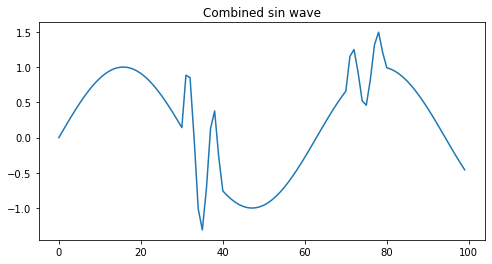

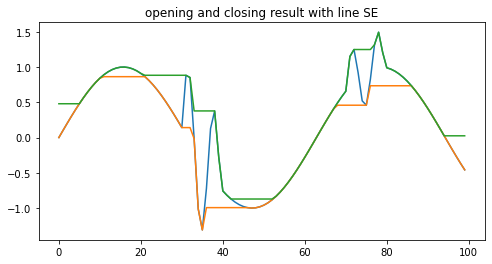

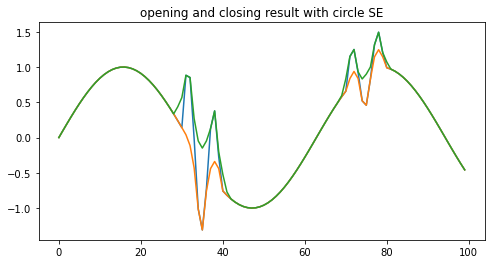

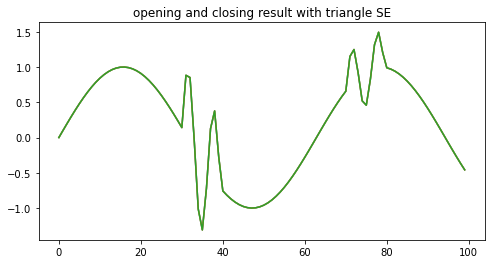

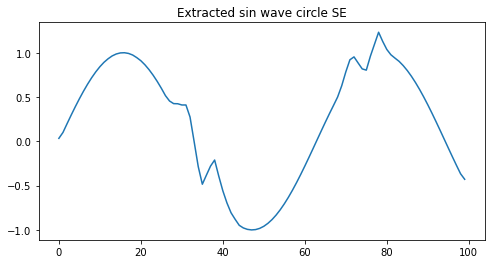

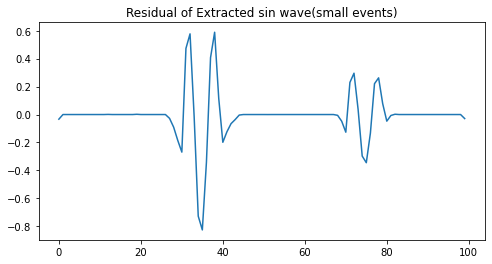

In [2]:
time        = np.arange(0, 10, 0.1);
data   = np.sin(time)
data_add = np.sin(np.arange(0,10))
data[30:40] = data[30:40] + data_add
data[70:80] = data[70:80] + data_add*0.5
r = 5
plt.figure(figsize=(8,4))
plt.title("Combined sin wave")
plt.plot(data)
plt.show()

def erosion(data,se):
  r = (len(se)-1)/2
  l = len(se)
  data = np.insert(data,0,data[0].repeat(r),0)
  data = np.append(data,data[-1].repeat(r))
  result = np.zeros(len(data)-len(se)+1)
  for i in range(len(data)-len(se)+1):
    result[i] = min(data[i:i+len(se)]-se)
  return result

def dilation(data,se):
  r = (len(se)-1)/2
  l = len(se)
  data = np.insert(data,0,data[0].repeat(r),0)
  data = np.append(data,data[-1].repeat(r))
  result = np.zeros(len(data)-len(se)+1)
  for i in range(len(data)-len(se)+1):
    result[i] = max(data[i:i+len(se)]+se)
  return result

def opening(data,se):
  data = erosion(data,se)
  data = dilation(data,se)
  return data

def closing(data,se):
  data = dilation(data,se)
  data = erosion(data,se)
  return data

se = structure_element(5,0)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with line SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,1)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with circle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,2)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with triangle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(15,1)
data1 = opening(data,se)
data2 = closing(data,se)
sin_extract = (data1+data2)/2
residual = data - sin_extract

plt.figure(figsize=(8,4))
plt.title("Extracted sin wave circle SE")
plt.plot(sin_extract)
plt.show()

plt.figure(figsize=(8,4))
plt.title("Residual of Extracted sin wave(small events)")
plt.plot(residual)
plt.show()

[17164. 16230. 15640. ... 20943. 20401. 15618.]


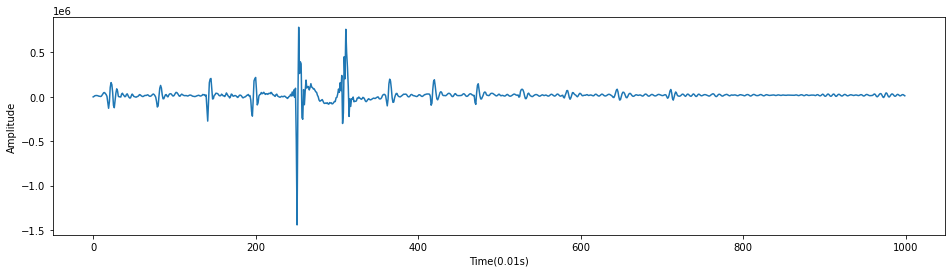

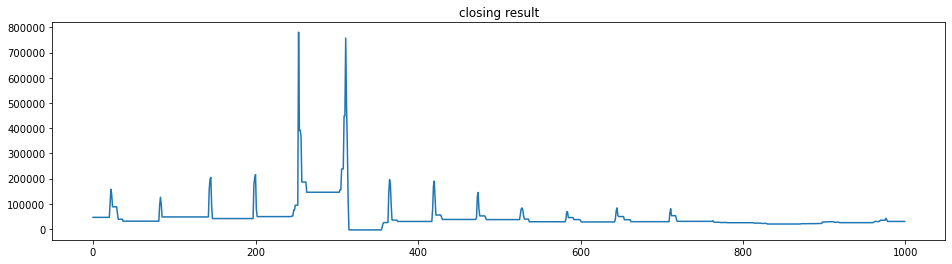

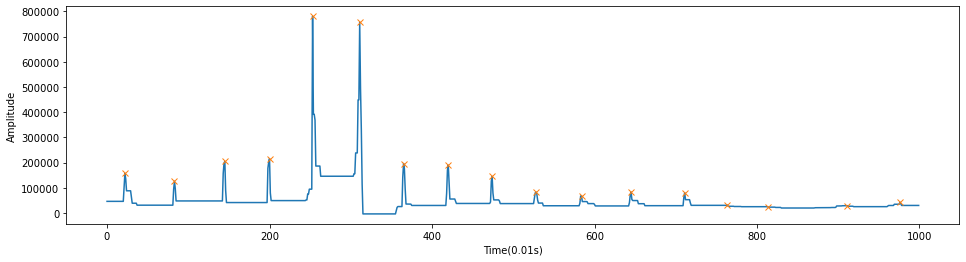

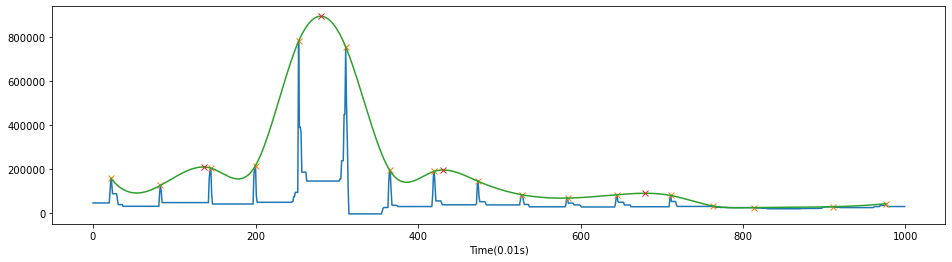

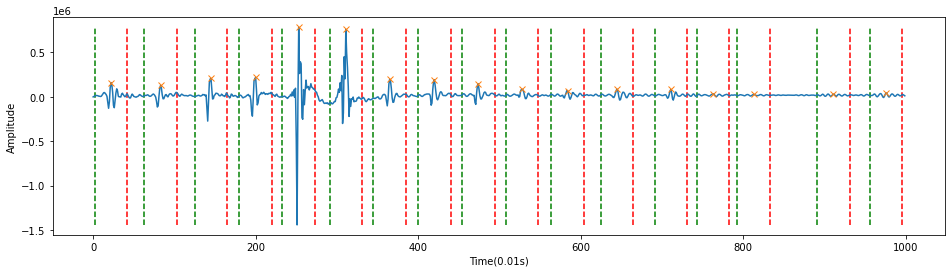

In [7]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp

from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack
import pandas as pd

'''
ip = "sensorweb.us" 
unit = "b8:27:eb:48:68:fa" # FloorB
stampIni = "2020-08-22T00:42:41.000Z" # UTC time = EST time + 4
stampEnd = "2020-08-22T00:43:00.000Z"
client = InfluxDBClient(ip, "8086", "sili", "sensorweb", "floorseis",   True)
# Check FloorB at http://3.136.84.223:3000/d/3HdIpxGMz/s-house-dashboard-raw-data-only?orgId=1&from=1594149493945&to=1594149503005

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '
result = client.query(query)
points = list(result.get_points())
values =  map(operator.itemgetter('value'), points)
times  =  map(operator.itemgetter('time'),  points)
data = np.array(list(values))
if(len(data) == 0):
  print("No data in the chosen time range!")
  quit()
'''

with open('silistep910.csv', newline='') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=';')
     seis = []
     for row in spamreader:
         seis.append(row[2])
     seis.pop(0)
     seis = np.array(seis)
     seis = seis.astype(np.float)
     print(seis)

        
data = seis[2000:3000]


plt.figure(figsize=(16,4))
#plt.title("Event samples")
plt.ylabel('Amplitude')
plt.xlabel('Time(0.01s)')
plt.plot(data)
plt.show()





se = structure_element(20,1)
data1 = opening(data,se)
data2 = closing(data,se)
sin_extract = (data1+data2)/2
residual = data - sin_extract

dataclose = data
for i in range(5,10):
    multise = structure_element(i,1)
    dataclose = closing(dataclose,multise)

plt.figure(figsize=(16,4))
plt.title("closing result")
plt.plot(data2)
plt.show()


####### peak detection
x = data2
peaks1, _ = sp.signal.find_peaks(x, height=0)

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Amplitude')
#plt.title("Finding peaks with closing curve, and finding peaks over the curve of peaks ")
plt.plot(x)
plt.plot(peaks1, x[peaks1], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

values = np.zeros((1,len(peaks1)))
cValues = 0;
for val in peaks1:
      values[0,cValues] = x[val]
      cValues = cValues + 1
values = values.ravel()

xvals = np.linspace(0, 3000, 3000)
x2 = sp.interpolate.interp1d(peaks1,values, kind='cubic',bounds_error=False)(xvals)
peaks2, _ = sg.find_peaks(x2, height=0)

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
#plt.ylabel('Curve of peaks')
#plt.title("Finding peaks over the curve of peaks")
plt.plot(x)
plt.plot(peaks1, x[peaks1], "x")
plt.plot(x2)
plt.plot(peaks2, x2[peaks2], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

y_min=min(data)
y_max=max(data)
plt.figure(figsize=(16, 4))
plt.ylabel('Amplitude')
plt.xlabel('Time(0.01s)')
#plt.title("Automatic segmentation with mathematical morphology")
#plt.plot(x2)
plt.plot(data)
plt.plot(peaks1, x[peaks1], "x")
plt.vlines(peaks1-20, y_min, y_max, 'g', '--', label='example')
plt.vlines(peaks1+20, y_min, y_max, 'r', '--', label='example')
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

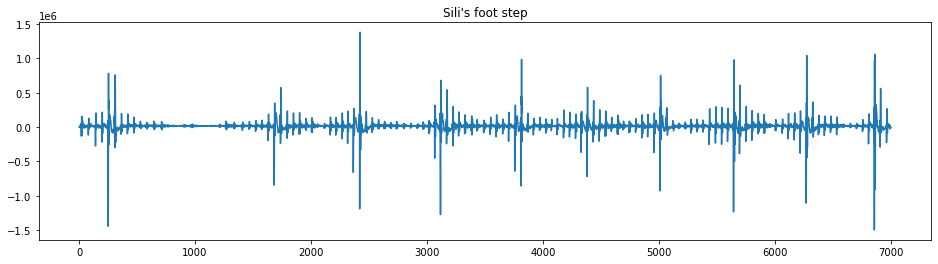

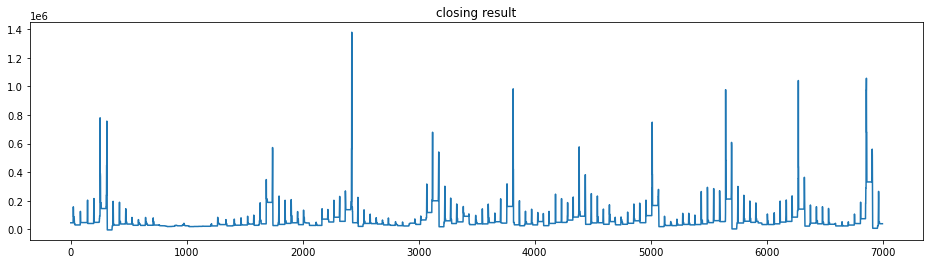

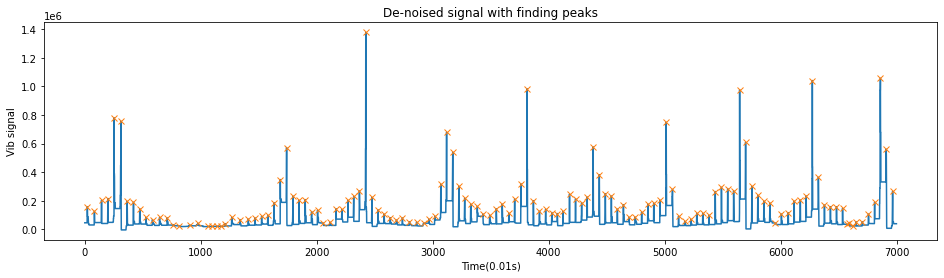

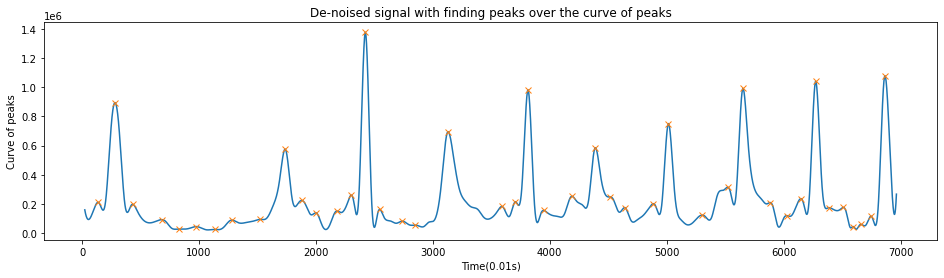

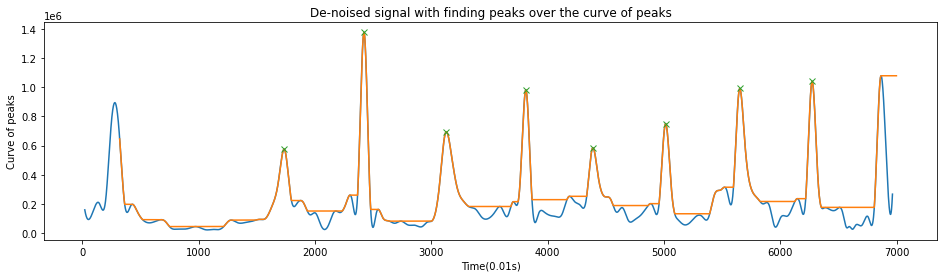

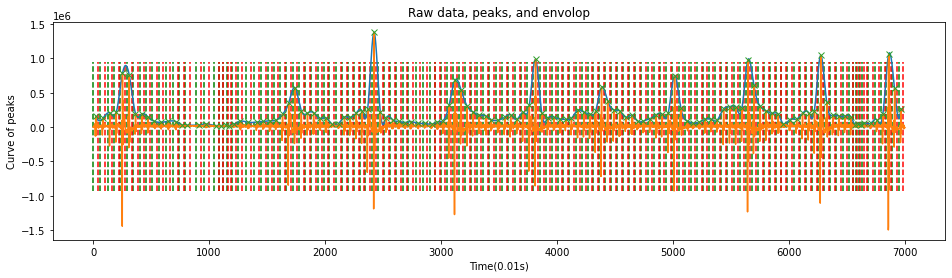

In [61]:
data = seis[2000:9000]


plt.figure(figsize=(16,4))
plt.title("Sili's foot step")
plt.plot(data)
plt.show()





se = structure_element(20,1)
data1 = opening(data,se)
data2 = closing(data,se)
sin_extract = (data1+data2)/2
residual = data - sin_extract

dataclose = data
for i in range(5,10):
    multise = structure_element(i,1)
    dataclose = closing(dataclose,multise)

plt.figure(figsize=(16,4))
plt.title("closing result")
plt.plot(data2)
plt.show()


####### peak detection
x = data2
peaks1, _ = sp.signal.find_peaks(x, height=0)

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Vib signal')
plt.title("De-noised signal with finding peaks")
plt.plot(x)
plt.plot(peaks1, x[peaks1], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

values = np.zeros((1,len(peaks1)))
cValues = 0;
for val in peaks1:
      values[0,cValues] = x[val]
      cValues = cValues + 1
values = values.ravel()

xvals = np.linspace(0, len(data), len(data))
x2 = sp.interpolate.interp1d(peaks1,values, kind='cubic',bounds_error=False)(xvals)
peaks2, _ = sg.find_peaks(x2, height=0)

se = structure_element(150,0)
x3 = closing(x2,se)


plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Curve of peaks')
plt.title("De-noised signal with finding peaks over the curve of peaks")
plt.plot(x2)
#plt.plot(x3)
plt.plot(peaks2, x2[peaks2], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

peaks3, _ = sg.find_peaks(x3, height=0)

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Curve of peaks')
plt.title("De-noised signal with finding peaks over the curve of peaks")
plt.plot(x2)
plt.plot(x3)
plt.plot(peaks3, x3[peaks3], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

plt.figure(figsize=(16, 4))
plt.xlabel('Time(0.01s)')
plt.ylabel('Curve of peaks')
plt.title("Raw data, peaks, and envolop")
plt.plot(x2)
plt.plot(data)
plt.plot(peaks1, x[peaks1], "x")
plt.vlines(peaks1-20, y_min, y_max, 'g', '--', label='example')
plt.vlines(peaks1+20, y_min, y_max, 'r', '--', label='example')
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

maximum level is 6


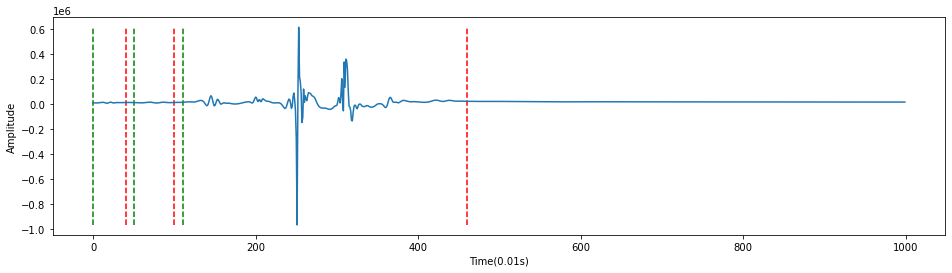

In [8]:
def wdenoise(data, method, threshold):
    # Create wavelet object and define parameters
    w = pywt.Wavelet(method)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, method, level=maxlev)  
    #cA = 0.0
    #cA = pywt.threshold(cA, threshold*max(cA))
    # plt.figure()
    for i in range(1, len(coeffs)):
        # plt.subplot(maxlev, 1, i)
        # plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        # plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, method)
    return datarec


if(len(data) == 0):
  print("No data in the chosen time range!")
  quit()

# denoising with wavelet
#datarec = wdenoise(data, 'db8', 0.04) # 
#data = seis[2000:6000]
datarec = wdenoise(data, 'db8', 0.24) # 
# foot step separation
mintime = 0
maxtime = mintime + len(data) + 1
ind = len(data)

## window size
window_size = 10
FLAG = False
threshold_of_std = 300
data_std_list = []
green_line = []
red_line = []
## run over the data
for i in range(0,len(datarec)-window_size,window_size):
    # print(datarec[i:i+window_size])
    window_data_std = np.std(np.asarray(datarec[i:i+window_size]))
    data_std_list.append(window_data_std)
    # exit()

    if FLAG == False:
        if window_data_std > threshold_of_std:
            FLAG = True
            green_line.append(i)
        else:
            pass

    else:
        if window_data_std <= threshold_of_std:
            FLAG = False
            red_line.append(i)

# print(max(see))
y_min = min(datarec)
y_max = max(datarec)

plt.figure(figsize=(16, 4))
plt.ylabel('Amplitude')
plt.xlabel('Time(0.01s)')
#plt.title("Automatic segmentation with wavelet techniques")
plt.plot(datarec) # [mintime:maxtime-1])
plt.vlines(green_line, y_min, y_max, 'g', '--', label='example')
plt.vlines(red_line, y_min, y_max, 'r', '--', label='example')
plt.show()

data = datarec
